In [2]:
import numpy as np

In [465]:
# data
#-5.38210006,
quad = [ -4.24154984, -3.71824052, -3.17573903, -2.5, -1.99949716] 
#1.59568569e-04,
xrms = [ 8.75908038e-05, 8.55396626e-05, 4.85704395e-05, 6e-5, 7.99284069e-05]
xerr = 0.4*np.array(xrms)#[ 0.3*8.75908038e-05, 0.2*8.55396626e-05, 0.3*4.85704395e-05, 0.5*6e-5, 0.2*7.99284069e-05]
#9.65669677e-05,

yquad = [-5.38210006, -3.71824052, -3.17573903,  -1.99949716] 
yrms = [9.65669677e-05,  4.721770e-05, 4.2127438e-05, 5.86293035e-05]
yerr = 0.1*np.array(yrms)
#yerr = [ 0.1*8.75908038e-05, 0.3*8.55396626e-05, 0.8*4.85704395e-05, 0.1*6e-5]

#18.31%, 22.38%, 24.30%
#0.7285878976068937 [[0.07941099]]

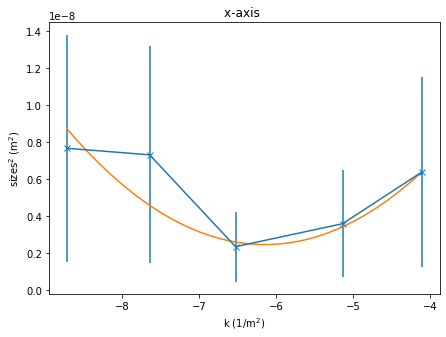

31.12%, 32.93%, 32.22%
0.7324868346270406 [[0.1126152]]


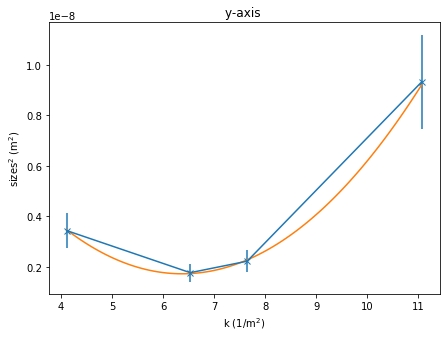

3.85%, -4.11%, 3.92%
0.36705516883061673 [[0.00756105]]
nemitx: 0.73, nemity: 0.37
nemitx_err: 0.45, nemity_err: 0.15
bmagx: 7.02, bmagy: 2.05


In [466]:
emittance = get_normemit(0.135, quad, yquad, xrms, np.array(yrms), adapt_ranges=False, show_plots=True)

In [444]:
#import numpy.polynomial.polynomial as poly
import datetime
import numpy as np 
import warnings
import sys, os, errno

m_0 = 0.511*1e-3 # mass in [GeV]
d = 2.26 # [m] distance between Q525 and OTR2
l = 0.108 # effective length [m]

# function to create path to output if dir was not created before
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def get_gradient(b_field, l_eff=0.108):
    """Returns the quad field gradient [T/m] 
        l_eff: effective length [m] 
        b_field: integrated field [kG]"""
    return np.array(b_field)*0.1 /l_eff
    
def get_k1(g, p):
    """Returns quad strength [1/m^2]
       g: quad field gradient [T/m]
       p: momentum [GeV] (or alternatively beta*E [GeV])"""
    return 0.2998 * g / p

def fit_sigma(sizes, k, axis, d=d, l=l, adapt_ranges=False, num_points=5, show_plots=False):
    """Fit sizes^2 = c0 + c1*k + c2*k^2
       returns: c0, c1, c2"""
    sizes_err = 2*sizes*np.array(xerr) if axis=='x' else 2*sizes*np.array(yerr)
    w = 1/sizes_err if sizes_err.all()>0 else None
    coefs, cov = np.polyfit(k, sizes**2, 2, w=w, cov=True) 
    
    # error on coefficienfs from cov matrix
    coefs_err = np.sqrt(np.diag(cov))
    
    if axis == 'x':
        min_k, max_k = np.min(k), np.max(k)
    elif axis == 'y':
        min_k, max_k = np.min(k), np.max(k)
    
    xfit = np.linspace(min_k, max_k, 100)

    #plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
    
    if adapt_ranges:
        try:
            coefs = adapt_range(k, sizes, coefs, xfit, axis=axis, num_points=num_points,\
                                save_plot=True, show_plots=show_plots)
            # log data
            timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
            if axis=="x":
                save_data(timestamp,0,0,0,0,sizes,0,k,0,str(adapt_ranges))
            if axis=="y":
                save_data(timestamp,0,0,0,0,0,sizes,0,k,str(adapt_ranges))
#         except NameError:
#             print("Error: A function to get beamsizes is not defined. Returning original fit.")
#             plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
        except ValueError:
            print("Error: Cannot adapt quad ranges. Returning original fit.")
            plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
        except InvertedFitError:
            print("Error: Cannot adapt quad ranges due to inverted poly. Returning original fit.")
            plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)     
    else:
        plot_fit(k, sizes, coefs, xfit, yerr=sizes_err, axis=axis, save_plot=True, show_plots=show_plots)
    
        
    # poly.poly: return c0,c1,c2
    # np.polyfit: highest power first
    c2, c1, c0 = coefs
    c2_err, c1_err, c0_err = coefs_err
    
    # matrix elements at quad 525
    sig_11 = c2 / (d*l)**2
    sig_12 = (-c1 - 2*d*l*sig_11) / (2*d**2*l)
    sig_22 = (c0 - sig_11 - 2*d*sig_12) / d**2
    
    # errors, assuming d and l have no error
    sig_11_err = c2_err/(d*l)**2
    sig_12_err = np.sqrt((c1_err/(2*d**2*l))**2 + (sig_11_err/d)**2 )
    sig_22_err = np.sqrt((c0_err/d**2)**2 + (sig_11_err/d**2)**2 + (sig_12_err*2/d)**2)           
    
#     print(f"{sig_11_err/sig_11*100:.2f}%, {sig_12_err/sig_12*100:.2f}%, {sig_22_err/sig_22*100:.2f}%")
    print(f"{c0_err/c0*100:.2f}%, {c1_err/c1*100:.2f}%, {c2_err/c2*100:.2f}%")

    emit2 = (4*c0*c2 - c1**2) / l**2 / (4 * d**4)
    emit = np.sqrt(emit2)
    
    emit_gradient = 1./(4*l*d**2*emit) * np.array([[4*c0, -2*c1, 4*c2]]).T
    emit_err = np.sqrt(np.matmul(np.matmul(emit_gradient.T, cov), emit_gradient))

    print(264.1859*emit/1e-6, 264.1859*emit_err/1e-6)
    
    return sig_11, sig_12, sig_22, sig_11_err, sig_12_err, sig_22_err

def get_emit(sig11, sig12, sig22, sig11_err, sig12_err, sig22_err):
    """Returns emittance (not normalized)"""
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            emit  = np.sqrt(sig11*sig22 - sig12**2)
            emit_err = np.sqrt((sig11_err/sig11)**2 + (2*sig12_err/sig12)**2 + (sig22_err/sig22)**2) * emit
            return emit, emit_err
    except RuntimeWarning:
        return np.nan 
    
def get_bmag(sig11, sig12, sig22, emit, axis):
    """Calculates Bmag from calculated emittance
    and from initial Twiss at OTR2: HARDCODED from Matlab GUI"""
    # HARDCODED INIT TWISS PARAMS
    twiss0 = [1e-6, 1e-6, 1.113081026, 1.113021659, -6.89403587e-2, -7.029489754e-2]
    
    beta0 =  twiss0[2] if axis == 'x' else twiss0[3] if axis == 'y' else 0
    alpha0 = twiss0[4] if axis == 'x' else twiss0[5] if axis == 'y' else 0
    gamma0 = (1+alpha0**2)/beta0

    beta = sig11/emit
    alpha = -sig12/emit
    gamma = sig22/emit
    
    bmag = 0.5 * (beta*gamma0 - 2*alpha*alpha0 + gamma*beta0)
    return bmag

def get_normemit(energy, xrange, yrange, xrms, yrms, adapt_ranges=False, num_points=5, show_plots=False):
    """Returns normalized emittance [m]
       given quad values and beamsizes"""    
    mkdir_p("plots")
    gamma = energy/m_0
    beta = np.sqrt(1-1/gamma**2)

    kx = get_k1(get_gradient(xrange), beta*energy)
    ky = get_k1(get_gradient(yrange), beta*energy)
    
    sig_11, sig_12, sig_22, sig_11_err, sig_12_err, sig_22_err = \
                                       fit_sigma(np.array(xrms), kx, axis='x',\
                                       adapt_ranges=adapt_ranges, num_points=num_points, show_plots=show_plots)
    
    emitx, emitx_err = get_emit(sig_11, sig_12, sig_22, sig_11_err, sig_12_err, sig_22_err)
    bmagx = get_bmag(sig_11, sig_12, sig_22, emitx, axis='x')

    sig_11, sig_12, sig_22, sig_11_err, sig_12_err, sig_22_err = \
                                       fit_sigma(np.array(yrms), -ky, axis='y',\
                                       adapt_ranges=adapt_ranges, num_points=num_points, show_plots=show_plots)
    
    emity, emity_err = get_emit(sig_11, sig_12, sig_22, sig_11_err, sig_12_err, sig_22_err)
    bmagy = get_bmag(sig_11, sig_12, sig_22, emity, axis='y')
    
    # log data
    timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
    save_data(timestamp,emitx*gamma*beta,emity*gamma*beta,bmagx,bmagy,xrms,yrms,kx,ky,str(adapt_ranges))
        
    if np.isnan(emitx) or np.isnan(emity):
        return np.nan, np.nan, np.nan, np.nan
    
    print(f"nemitx: {emitx*gamma*beta/1e-6:.2f}, nemity: {emity*gamma*beta/1e-6:.2f}")
    print(f"nemitx_err: {emitx_err*gamma*beta/1e-6:.2f}, nemity_err: {emity_err*gamma*beta/1e-6:.2f}")
    print(f"bmagx: {bmagx:.2f}, bmagy: {bmagy:.2f}")

    return emitx*gamma*beta, emity*gamma*beta, bmagx, bmagy

def plot_fit(x, y, fit_coefs, x_fit, axis, yerr=None, save_plot=True, show_plots=False, title_suffix=""):
    """Plot and save the emittance fits of size**2 vs k"""
    import matplotlib.pyplot as plt
    import datetime
    fig = plt.figure(figsize=(7,5))
    ffit = np.poly1d(fit_coefs)
    plt.errorbar(x, y**2, yerr=yerr, marker="x")
    plt.plot(x_fit, np.polyval(fit_coefs, x_fit))
    
    #print(repr(x_fit), repr(np.polyval(fit_coefs, x_fit)))
    
    plt.xlabel(r"k (1/m$^2$)")
    plt.ylabel(r"sizes$^2$ (m$^2$)")
    plt.title(f"{axis}-axis "+title_suffix)
    timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
    
    if save_plot:
        try:
            plt.savefig(f"./plots/emittance_{axis}_fit_{timestamp}.png", dpi=100)
        except:
            plt.savefig(f"./emittance_fit_{axis}_{timestamp}.png", dpi=100)
    if show_plots:
        plt.show()
    plt.close()
        
def get_quad_field(k, energy=0.135, l=0.108): 
    """Get quad field [kG] from k1 [1/m^2]"""
    gamma = energy/m_0
    beta = np.sqrt(1-1/gamma**2)
    return np.array(k)*l/0.1/0.2998*energy*beta


def adapt_range(x, y, fit_coefs, x_fit, axis, num_points, save_plot=False, show_plots=True):
    """Adjust scanning range for a given axis to fit around minimum"""
    if axis == 'x':
        min_x, max_x = np.min(x), 0
        # quad ranges 0 to -10 kG for scanning
        min_x_range, max_x_range = -22.2, 0
    elif axis == 'y':
        min_x, max_x = np.min(x), np.max(x)
        # quad ranges 0 to -10 kG for scanning
        min_x_range, max_x_range = 0, 22.2
        
    c2, c1, c0 = fit_coefs
    
    if c2<0:
        inverted_function = True
    else:
        inverted_function = False
    
    # find range within 2-3x the focus size 
    y_lim = np.min(np.polyval(x_fit, fit_coefs))*4 
    if y_lim<0:
        print(f"{axis} axis: min. of poly fit is negative. Setting it to 0.")
        y_lim = 0
    roots = np.polyroots((c0-y_lim, c1, c2))
    # Flag bad fit with complex roots
    if np.iscomplex(roots).any():
        print("Bad emittance fit, complex root encountered.")
        raise ValueError("Cannot adapt quad ranges.")
    
    # if roots are outside quad scanning range, set to scan range lim
    if roots[0]<min_x_range:
        roots[0] = min_x_range
    if roots[1]>max_x_range:
        roots[1] = max_x_range
        
    # have at least 3 scanning points within roots
    range_fit = np.max(roots)-np.min(roots)
    if range_fit<2:
        # need at least 3 points for polynomial fit
        x_fine_fit = np.linspace(np.min(roots)-1.5, np.max(roots)+1.5, num_points)
        
    if inverted_function:
        print("Adjusting inverted poly.")
        # go to minimum side of inverted polynomials
        x_min_inverted = x[np.argmin(y)]
        
        #find the direction of sampling to minimum
        if (x[np.argmin(y)] - x[np.argmin(y)-2])<0:
            x_max_inverted = min_x_range
        else:
            x_max_inverted = max_x_range
        
        if (x_max_inverted-x_min_inverted)>8:
            # if range is too big, narrow it down on the larger side
            x_min_inverted = x_min_inverted - 4
            
        x_fine_fit = np.linspace(x_min_inverted, x_max_inverted, num_points)
        
    elif (np.max(roots)-np.min(roots))>8:
        # need to concentrate around min!
        dist_min = np.abs(x[np.argmin(y)]-np.min(roots))
        dist_max = np.abs(x[np.argmin(y)]-np.max(roots))
        if dist_min<dist_max:
            x_fine_fit = np.linspace(np.min(roots), np.max(roots)-4, num_points)
        elif dist_min>dist_max:
            x_fine_fit = np.linspace(np.min(roots)+4, np.max(roots), num_points)
        else:
            x_fine_fit = np.linspace(np.min(roots)+2, np.max(roots)-2, num_points)
            
    else:
        x_fine_fit = np.linspace(roots[0], roots[1], num_points)

        
    # GET NEW BEAMSIZES 
    # this takes B in kG not K
    if axis=="x":
        fine_fit_sizes = np.array([get_updated_beamsizes(get_quad_field(ele))[0] for ele in x_fine_fit])
    elif axis == "y":
        fine_fit_sizes = np.array([get_updated_beamsizes(-get_quad_field(ele))[1] for ele in x_fine_fit])
    
    # fit
    coefs = np.polyfit(x_fine_fit, fine_fit_sizes**2, 2)
    xfit = np.linspace(np.min([min_x,np.min(x_fine_fit)]),np.max([max_x,np.max(x_fine_fit)]), 100)
    plot_fit(x_fine_fit, fine_fit_sizes, coefs, xfit, axis=axis, save_plot=save_plot, show_plots=show_plots)
    
    return coefs

def save_data(timestamp, nex, ney, bmx, bmy, xsizes, ysizes, kx, ky, adapted):
    f= open(f"emit_calc_log.csv", "a+")
    f.write(f"{timestamp},{nex},{ney},{bmx},{bmy},{xsizes},{ysizes},{kx},{ky},{adapted}\n")
    f.close()
    
class InvertedFitError(Exception):
    """Raised when the adapted range emit 
    fit results in inverted polynomial"""
    pass

In [ ]:
def linear_err_prop(sig_err, corr_coef, lin_coef):
    # correlation error contribution
    for i in sig_err:
        
    # error on linear function with correlated variables
    sig_f_squared = np.sum(lin_coef**2 * sig_err**2) + \
                    np.sum

In [77]:
yrange = np.array([4.11147835, 4.15804637, 4.2046144 , 4.25118243, 4.29775045,
       4.34431848, 4.39088651, 4.43745453, 4.48402256, 4.53059059,
       4.57715861, 4.62372664, 4.67029467, 4.71686269, 4.76343072,
       4.80999874, 4.85656677, 4.9031348 , 4.94970282, 4.99627085,
       5.04283888, 5.0894069 , 5.13597493, 5.18254296, 5.22911098,
       5.27567901, 5.32224704, 5.36881506, 5.41538309, 5.46195112,
       5.50851914, 5.55508717, 5.6016552 , 5.64822322, 5.69479125,
       5.74135928, 5.7879273 , 5.83449533, 5.88106336, 5.92763138,
       5.97419941, 6.02076744, 6.06733546, 6.11390349, 6.16047151,
       6.20703954, 6.25360757, 6.30017559, 6.34674362, 6.39331165,
       6.43987967, 6.4864477 , 6.53301573, 6.57958375, 6.62615178,
       6.67271981, 6.71928783, 6.76585586, 6.81242389, 6.85899191,
       6.90555994, 6.95212797, 6.99869599, 7.04526402, 7.09183205,
       7.13840007, 7.1849681 , 7.23153613, 7.27810415, 7.32467218,
       7.37124021, 7.41780823, 7.46437626, 7.51094428, 7.55751231,
       7.60408034, 7.65064836, 7.69721639, 7.74378442, 7.79035244,
       7.83692047, 7.8834885 , 7.93005652, 7.97662455, 8.02319258,
       8.0697606 , 8.11632863, 8.16289666, 8.20946468, 8.25603271,
       8.30260074, 8.34916876, 8.39573679, 8.44230482, 8.48887284,
       8.53544087, 8.5820089 , 8.62857692, 8.67514495, 8.72171297]) 

yrms = np.array([3.44781148e-09, 3.40374588e-09, 3.36051148e-09, 3.31810830e-09,
       3.27653634e-09, 3.23579558e-09, 3.19588604e-09, 3.15680771e-09,
       3.11856060e-09, 3.08114470e-09, 3.04456001e-09, 3.00880653e-09,
       2.97388427e-09, 2.93979322e-09, 2.90653339e-09, 2.587410476e-09,
       2.84250736e-09, 2.51174116e-09, 2.78180618e-09, 2.75270241e-09,
       2.72442985e-09, 2.69698851e-09, 2.67037838e-09, 2.64459946e-09,
       2.61965176e-09, 2.59553526e-09, 2.57224999e-09, 2.54979592e-09,
       2.52817307e-09, 2.50738143e-09, 2.48742101e-09, 2.46829180e-09,
       2.54999380e-09, 2.43252701e-09, 2.41589144e-09, 2.20008708e-09,
       2.38511394e-09, 2.37097200e-09, 2.35766128e-09, 2.34518178e-09,
       2.33353348e-09, 2.32271640e-09, 2.31273054e-09, 2.30357588e-09,
       2.29525244e-09, 2.28776022e-09, 2.28109920e-09, 2.27526940e-09,
       2.57027081e-09, 2.26610344e-09, 2.26276728e-09, 2.5026233e-09,
       2.25858859e-09, 2.25774607e-09, 2.25773476e-09, 2.25855467e-09,
       2.26020578e-09, 2.26268811e-09, 2.26600166e-09, 2.5014642e-09,
       2.27512239e-09, 2.28092957e-09, 2.28756797e-09, 2.29503758e-09,
       2.30333840e-09, 2.31247043e-09, 2.32243368e-09, 2.23322815e-09,
       2.34485382e-09, 2.35731071e-09, 2.57059881e-09, 2.5471813e-09,
       2.5966866e-09, 2.41545040e-09, 2.23206335e-09, 2.44950752e-09,
       2.2778290e-09, 2.288949e-09, 2.50682730e-09, 2.52759632e-09,
       2.54919656e-09, 2.57162800e-09, 2.59489066e-09, 2.61898454e-09,
       2.64390962e-09, 2.66966592e-09, 2.69625343e-09, 2.72367216e-09,
       2.45192210e-09, 2.28100325e-09, 2.81091562e-09, 2.84165919e-09,
       2.87323399e-09, 2.90563999e-09, 2.0887721e-09, 2.2294564e-09,
       3.00784528e-09, 3.04357614e-09, 3.08013821e-09, 3.2753150e-09])

yerr = 0.1*np.array(yrms)

In [243]:
xerr

array([1.35633284e-05, 7.44521832e-06, 5.57087132e-06, 4.12848736e-06,
       5.10000000e-06, 6.79391459e-06])

In [244]:
xerr.all()>0

True